In [43]:
import LowLevelFEM as FEM
using LowLevelFEM
using SparseArrays
using LinearAlgebra
using Plots
using Arpack

gmsh.initialize()

In [96]:
plotlyjs()

┌ Warning: backend `PlotlyJS` is not installed.
└ @ Plots /home/perebal/.julia/packages/Plots/ju9dp/src/backends.jl:43


Plots.PlotlyJSBackend()

In [44]:
gmsh.open("wave_propagation_1D.geo")

Info    : Reading 'wave_propagation_1D.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000475897s, CPU 0.000478s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00126625s, CPU 0.001263s)
Info    : 303 nodes 408 elements
Info    : Done reading 'wave_propagation_1D.geo'


In [45]:
mat = FEM.material("body", E=1.0, ν=0.0)
problem = FEM.Problem([mat], type="PlaneStress")

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 6)


LowLevelFEM.Problem("wave_propagation_1D", "PlaneStress", 2, [("body", 1.0, 0.0, 7.85e-9)], 1.0, 303)

In [46]:
supp = FEM.displacementConstraint("supp", ux=0)
load = FEM.load("supp", fx=0);

In [47]:
dof = problem.non * problem.dim
u0 = zeros(dof)
v0 = zeros(dof);

In [48]:
K = FEM.stiffnessMatrix(problem)

606×606 SparseMatrixCSC{Float64, Int64} with 8170 stored entries:
⎡⠻⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠘⢻⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠉⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⢿⣷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠘⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⣷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠿⣧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣶⣀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠿⣧⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⣄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢻⣶⣀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⠆⎦

In [49]:
M = FEM.massMatrix(problem)

606×606 SparseMatrixCSC{Float64, Int64} with 606 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠄⎦

In [50]:
f = FEM.loadVector(problem, [load])
dof

606

In [51]:
C = K * 0
FEM.applyBoundaryConditions!(problem, K, M, C, f, [supp]);

In [52]:
Tₘᵢₙ = FEM.smallestPeriodTime(K, M)

0.00027834581827027873

In [53]:
(2π / Tₘᵢₙ)^2

5.095541401273914e8

In [54]:
Tₘₐₓ = FEM.largestPeriodTime(K, M)

1.6260789848493251

In [55]:
(2π / Tₘₐₓ)^2

14.930572562141684

In [56]:
ω², ϕ = Arpack.eigs(K, M, nev=100, which=:SR, maxiter=1000)
ω²

100-element Vector{Float64}:
     1.7075804538212727e-7
     0.9999999207968111
     0.9999999772350189
     1.0000003446278907
    14.930572456823992
   434.54447985811345
  2634.9679599783904
  9040.194234793958
 23041.251608477323
 31431.21486356619
     ⋮
     1.0832437700782642e8
     1.1270255545509501e8
     1.1489864509601718e8
     1.1711581775490485e8
     1.2155623051452571e8
     1.2165641663287878e8
     1.2600614358448923e8
     1.2738853503184682e8
     1.275146761389327e8

In [57]:
ω², ϕ = eigen(collect(K), collect(M), sortby=abs)
Δt = 2π ./ .√(real.(abs.(ω²)))
ω²

606-element Vector{Float64}:
     1.4468011896807602e-7
     0.9999999999999086
     1.0
     1.0
    14.930572622170864
   434.54447968361467
  2634.9679599918704
  9040.194234839073
 23041.25160828962
 31431.214863200043
     ⋮
     5.0801553005227476e8
     5.085496434795513e8
     5.0876874744793034e8
     5.0898878529975533e8
     5.092713057227946e8
     5.093027679526461e8
     5.0949128157525235e8
     5.0952270891252476e8
     5.095541401273885e8

In [58]:
FEM.initialDisplacement!(problem, "supp", u0, ux=0)
FEM.initialVelocity!(problem, "body", v0, vx=1000)
FEM.initialVelocity!(problem, "supp", v0, vx=0)

In [59]:
α = -0.029 * 2.3
δ = 0.0477 * 1.8#/ 2.3

0.08586

In [60]:
ξ1 = [0.0092, 0.0034, 0.0002, 0.0001, 0.0001, 0.00015]
ξ2 = [0.0092]
ξ3 = [0.0092, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030];

In [61]:
ωₘᵢₙ = 2π / Tₘₐₓ
ωₘₐₓ = 2π / Tₘᵢₙ
Δt1 = Tₘᵢₙ / π * (√(1 + sum(ξ1)^2) - sum(ξ1)) * 0.98 / 1
Δt2 = Tₘᵢₙ / π * (√(1 + sum(ξ2)^2) - sum(ξ2)) * 0.98 / 1
Δt3 = Tₘᵢₙ / π * (√(1 + sum(ξ3)^2) - sum(ξ3)) * 0.98 / 1

8.475239958353433e-5

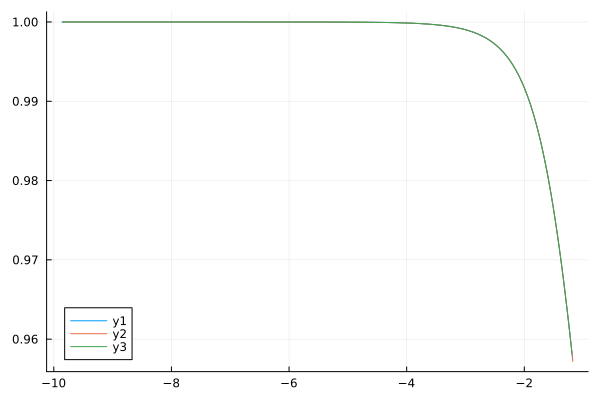

In [62]:
plt1 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "SR", n=1000, α=α, δ=δ)
plt2 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "SR", n=1000, α=α, δ=δ)
plt3 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "SR", n=1000, α=α, δ=δ)
plot(plt1)
plot!(plt2)
plot!(plt3)

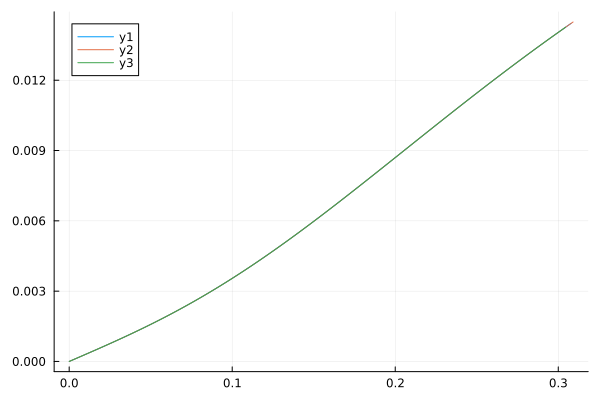

In [63]:
plt01 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "ADR", n=1000, α=α, δ=δ)
plt02 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "ADR", n=1000, α=α, δ=δ)
plt03 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "ADR", n=1000, α=α, δ=δ)
plot(plt01)
plot!(plt02)
plot!(plt03)

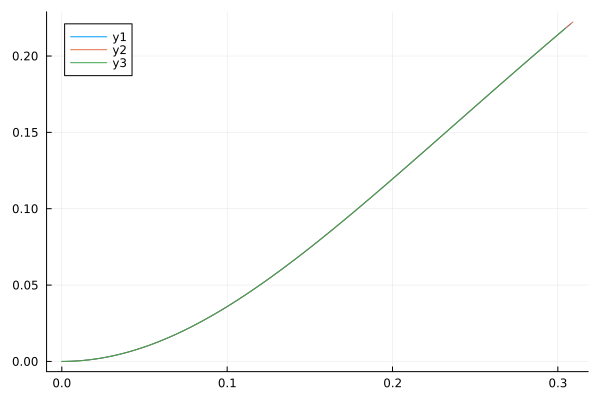

In [64]:
plt1 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "PE", n=1000, α=α, δ=δ)
plt2 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "PE", n=1000, α=α, δ=δ)
plt3 = FEM.HHTaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "PE", n=1000, α=α, δ=δ)
plot(plt1)
plot!(plt2)
plot!(plt3)

In [65]:
u11, v11, t11 = FEM.HHT(K, M, f, u0, v0, 1000Δt1, Δt1, α=α, δ=δ)
u12, v12, t12 = FEM.HHT(K, M, f, u0, v0, 1000Δt2, Δt2, α=α, δ=δ)
u13, v13, t13 = FEM.HHT(K, M, f, u0, v0, 1000Δt3, Δt3, α=α, δ=δ)

([0.0 0.0 … 0.0 0.0; 0.0 -2.4704424590854032e-17 … -2.4907520713913733e-12 -2.53987050698484e-12; … ; 0.0 0.08475239958353434 … 4.02982535404185 3.9417275797328037; 0.0 0.0 … 8.165232357733696e-13 8.306647928147718e-13], [0.0 0.0 … 0.0 0.0; 0.0 -5.793338541112403e-13 … -5.851307238814254e-10 -5.73987064441792e-10; … ; 1000.0 1000.0 … -1032.1801134593495 -1046.7882912613197; 0.0 0.0 … 1.2687384127959432e-10 2.0763782485498575e-10], [0.0, 8.475239958353433e-5, 0.00016950479916706866, 0.00025425719875060297, 0.0003390095983341373, 0.00042376199791767166, 0.0005085143975012059, 0.0005932667970847403, 0.0006780191966682746, 0.000762771596251809  …  0.08390487558770003, 0.08398962798728357, 0.08407438038686711, 0.08415913278645065, 0.08424388518603419, 0.08432863758561773, 0.08441338998520127, 0.08449814238478481, 0.08458289478436835, 0.0846676471839519])

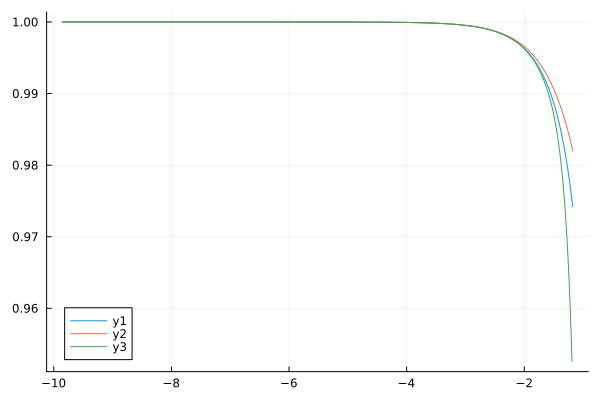

In [66]:
plt1 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "SR", n=1000, ξ=ξ1)
plt2 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "SR", n=1000, ξ=ξ2)
plt3 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "SR", n=1000, ξ=ξ3)
plot(plt1)
plot!(plt2)
plot!(plt3)

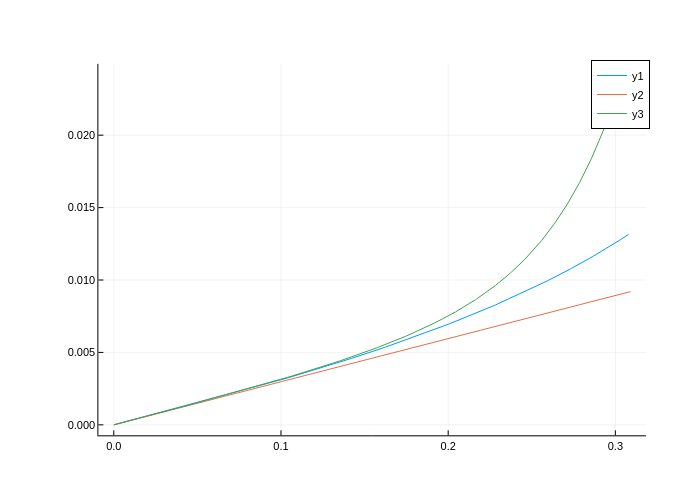

In [98]:
plt1 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "PDR", n=1000, ξ=ξ1)
plt2 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "PDR", n=1000, ξ=ξ2)
plt3 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "PDR", n=1000, ξ=ξ3)
plot(plt1)
plot!(plt2)
plot!(plt3)

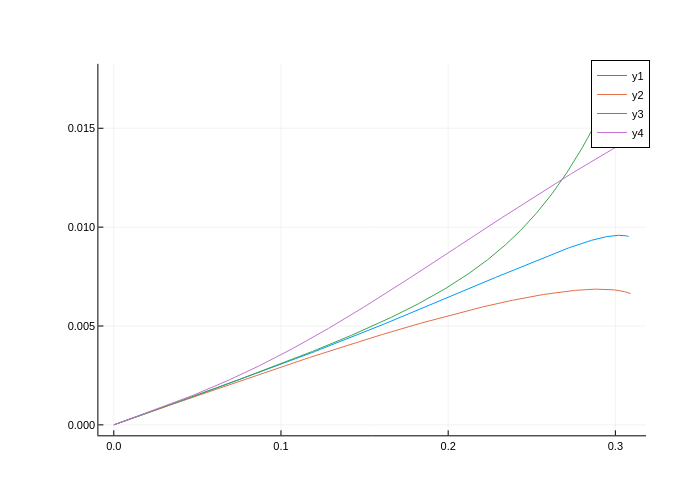

In [99]:
plt1 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "ADR", n=1000, ξ=ξ1)
plt2 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "ADR", n=1000, ξ=ξ2)
plt3 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "ADR", n=1000, ξ=ξ3)
plot(plt1)
plot!(plt2)
plot!(plt3)
plot!(plt01)

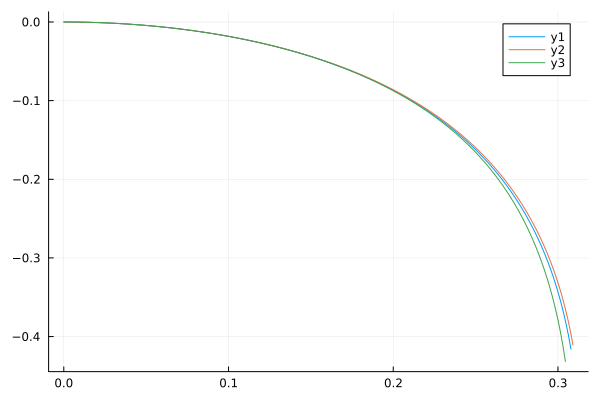

In [69]:
plt1 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt1, "PE", n=1000, ξ=ξ1)
plt2 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt2, "PE", n=1000, ξ=ξ2)
plt3 = FEM.CDMaccuracyAnalysis(ωₘᵢₙ, ωₘₐₓ, Δt3, "PE", n=1000, ξ=ξ3)
plot(plt1)
plot!(plt2)
plot!(plt3)

In [70]:
C1 = FEM.dampingMatrix(M, K, ωₘₐₓ, ξ=ξ1)
C2 = FEM.dampingMatrix(M, K, ωₘₐₓ, ξ=ξ2)
C3 = FEM.dampingMatrix(M, K, ωₘₐₓ, ξ=ξ3)

606×606 SparseMatrixCSC{Float64, Int64} with 45516 stored entries:
⎡⣿⣿⣿⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠻⣿⣿⣿⣿⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠉⢻⣿⣿⣿⣿⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⢻⣿⣿⣿⣿⣧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠿⣿⣿⣿⣿⣧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠘⠿⣿⣿⣿⣿⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣿⣿⣿⣿⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿⣿⣿⣿⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢻⣿⣿⣿⣿⣷⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⣿⣿⣿⣿⣧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⣿⣿⣿⣿⣧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠿⣿⣿⣿⣿⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣿⣿⣿⣿⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿⣿⣿⣿⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢻⣿⣿⣿⣿⣷⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⣿⣿⣿⣿⣧⣀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⣿⣿⣿⣿⣦⣀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣿⣿⣿⣿⣦⣄⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣿⣿⣿⣿⡇⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠿⠿⠿⠇⎦

In [71]:
u21, v21, t21 = FEM.CDM(K, M, C1, f, u0, v0, 1000Δt1, Δt1)
u22, v22, t22 = FEM.CDM(K, M, C2, f, u0, v0, 1000Δt2, Δt2)
u23, v23, t23 = FEM.CDM(K, M, C3, f, u0, v0, 1000Δt3, Δt3)

([0.0 0.0 … 0.0 0.0; 0.0 -1.012643268281901e-18 … -3.413264256046538e-13 -3.411825680968028e-13; … ; 0.0 0.08475239958353432 … 4.01733094896113 3.9325785493774026; 0.0 -1.895014646195122e-19 … -3.856198592603769e-13 -3.7919919517269626e-13], [0.0 0.0 … 0.0 0.0; 0.0 -1.1948254837124836e-14 … -3.589343642583782e-12 1.6973856617382135e-12; … ; 1000.0 1000.0 … -1000.0000000024507 -1000.0000000022831; 0.0 -2.2359421745072158e-15 … -9.39422969379842e-11 7.575790324794607e-11], [0.0, 8.475239958353433e-5, 0.00016950479916706866, 0.00025425719875060297, 0.0003390095983341373, 0.00042376199791767166, 0.0005085143975012059, 0.0005932667970847403, 0.0006780191966682746, 0.000762771596251809  …  0.08390487558770003, 0.08398962798728357, 0.08407438038686711, 0.08415913278645065, 0.08424388518603419, 0.08432863758561773, 0.08441338998520127, 0.08449814238478481, 0.08458289478436835, 0.0846676471839519])

In [83]:
S11 = FEM.solveStress(problem, u11)
S12 = FEM.solveStress(problem, u12)
S13 = FEM.solveStress(problem, u13)

LowLevelFEM.StressField([[0.0 -2.7755575615628914e-17 … -0.0008374696818327365 -0.0005326459472967393; 0.0 -6.938893903907228e-18 … 8.881784197001252e-15 8.881784197001252e-16; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … -0.0008374696818442828 -0.0005326459473082856; 0.0 0.0 … 1.3322676295501878e-15 -7.327471962526033e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 -1.3877787807814457e-17 … -0.0024011660298164372 -0.0015359253896787273; 0.0 6.938893903907228e-18 … -3.9968028886505635e-15 -5.773159728050814e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … -0.002401166029780022 -0.0015359253896498615; 0.0 0.0 … 1.1546319456101628e-14 -3.552713678800501e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 2.7755575615628914e-17 … -0.0036468372556948125 -0.002361363860495125; 0.0 1.3877787807814457e-17 … -4.440892098500626e-16 -1.1324274851176597e-14; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … -0.003646837255707247 -0.0023613638604782494; 0.0 6.938893903

In [73]:
S21 = FEM.solveStress(problem, u21)
S22 = FEM.solveStress(problem, u22)
S23 = FEM.solveStress(problem, u23)

LowLevelFEM.StressField([[0.0 0.0 … 1.7763568394002505e-15 1.2878587085651816e-14; 0.0 0.0 … 4.884981308350689e-15 1.3322676295501878e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 3.552713678800501e-15 6.217248937900877e-15; 0.0 0.0 … 8.881784197001252e-16 6.661338147750939e-16; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 1.7763568394002505e-14 1.9984014443252818e-14; 0.0 0.0 … 1.7763568394002505e-15 -1.9984014443252818e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 9.769962616701378e-15 1.9984014443252818e-14; 0.0 0.0 … -1.7763568394002505e-15 1.9984014443252818e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 2.930988785010413e-14 1.9984014443252818e-14; 0.0 0.0 … 3.1086244689504383e-15 2.886579864025407e-15; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 2.220446049250313e-14 1.509903313490213e-14; 0.0 0.0 … -4.440892098500626e-16 2.220446049250313e-16; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 1.4210854715202004e-14 2.

In [74]:
sx11 = FEM.showStressResults(problem, S11, "sx", name="σx1(t)", t=t11, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


8

In [84]:
sx12 = FEM.showStressResults(problem, S12, "sx", name="σx2(t)", t=t12, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


13

In [85]:
sx13 = FEM.showStressResults(problem, S13, "sx", name="σx3(t)", t=t13, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


14

In [77]:
sx21 = FEM.showStressResults(problem, S21, "sx", name="σx21(t)", t=t21, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


9

In [78]:
sx22 = FEM.showStressResults(problem, S22, "sx", name="σx22(t)", t=t22, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


10

In [79]:
sx23 = FEM.showStressResults(problem, S23, "sx", name="σx23(t)", t=t23, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


11

In [80]:
ph11, xy11 = FEM.plotOnPath(problem, "path", sx11, 500, name="σx1 HHT", step=90, plot=true, visible=true)
sum(abs, diff(xy11[2]))


0.20674874058989276

In [86]:
ph12, xy12 = FEM.plotOnPath(problem, "path", sx12, 500, name="σx2 HHT", step=90, plot=true, visible=true)
sum(abs, diff(xy12[2]))


0.2074986036744987

In [87]:
ph13, xy13 = FEM.plotOnPath(problem, "path", sx13, 500, name="σx3 HHT", step=90, plot=true, visible=true)
sum(abs, diff(xy13[2]))


0.20783748466545582

In [89]:
ph21, xy21 = FEM.plotOnPath(problem, "path", sx21, 500, name="σx1 CDM", step=90, plot=true, visible=true)
sum(abs, diff(xy21[2]))

0.09526726594932937

In [91]:
ph22, xy22 = FEM.plotOnPath(problem, "path", sx22, 500, name="σx2 CDM", step=90, plot=true, visible=true)
sum(abs, diff(xy22[2]))

0.10315463152587227

In [92]:
ph23, xy23 = FEM.plotOnPath(problem, "path", sx23, 500, name="σx3 CDM", step=90, plot=true, visible=true)
sum(abs, diff(xy23[2]))

0.09242088080720934

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/perebal/.jlassetregistry.lock
└ @ Pidfile /home/perebal/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


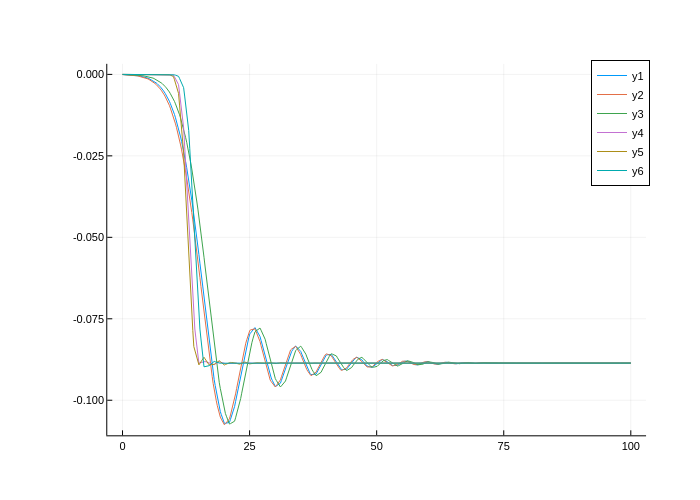

In [97]:
plot(xy11)
plot!(xy12)
plot!(xy13)
plot!(xy21)
plot!(xy22)
plot!(xy23)

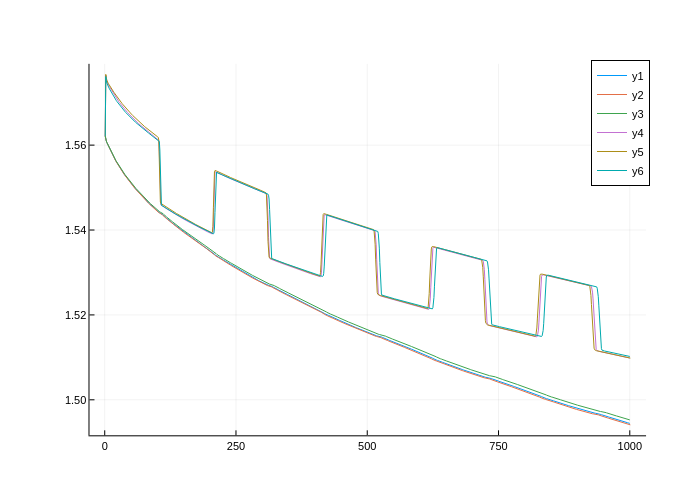

In [100]:
plot([u11[:, i]' * K * u11[:, i] + v11[:, i]' * M * v11[:, i] for i in 1:length(u11[1, :])])
plot!([u12[:, i]' * K * u12[:, i] + v12[:, i]' * M * v12[:, i] for i in 1:length(u12[1, :])])
plot!([u13[:, i]' * K * u13[:, i] + v13[:, i]' * M * v13[:, i] for i in 1:length(u13[1, :])])
plot!([u21[:, i]' * K * u21[:, i] + v21[:, i]' * M * v21[:, i] for i in 1:length(u11[1, :])])
plot!([u22[:, i]' * K * u22[:, i] + v22[:, i]' * M * v22[:, i] for i in 1:length(u12[1, :])])
plot!([u23[:, i]' * K * u23[:, i] + v23[:, i]' * M * v23[:, i] for i in 1:length(u13[1, :])])

In [667]:
#gmsh.fltk.run()

In [668]:
gmsh.finalize()